In [1]:
from pyspark.sql import SparkSession
from google.cloud import bigquery
import os

# Setăm calea către fișierul JSON pentru autentificare
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/able-stock-481820-i2-7fe2b44ed2ac.json"

# Creează o sesiune Spark
spark = SparkSession.builder \
    .appName("BigQuery to PySpark") \
    .getOrCreate()

# Conexiunea la BigQuery
project_id = "bigquery-public-data"
dataset = "new_york_citibike"  # MODIFICAT
table = "citibike_trips"      # MODIFICAT

bq_client = bigquery.Client()

# Modificarea: Am înlocuit coloanele Google Trends cu coloanele Citi Bike,
# mapând logicile aplicației (Durată, ID Stație, Distanță Similată).
query = f"""
    SELECT

        starttime,
        start_station_name,
        tripduration,
        start_station_id,

        CAST(tripduration * 0.001 AS FLOAT64) AS calculated_distance

    FROM `{project_id}.{dataset}.{table}`

    WHERE tripduration IS NOT NULL AND tripduration > 60 AND start_station_id IS NOT NULL
    LIMIT 10000
"""
query_job = bq_client.query(query)

# Convertim rezultatul în Pandas DataFrame și apoi în Spark DataFrame
pandas_df = query_job.to_dataframe()

# ATENȚIE: Coloanele din Spark DataFrame vor fi acum:
# 'week', 'term', 'score', 'rank', 'num_promotions' (mapate la logica originală).
spark_df = spark.createDataFrame(pandas_df)
spark_df.show(5)

+--------------------+--------------------+------------+----------------+-------------------+
|           starttime|  start_station_name|tripduration|start_station_id|calculated_distance|
+--------------------+--------------------+------------+----------------+-------------------+
| 2017-10-01 00:50:30|        WS Don't Use|         353|            3480|              0.353|
|2018-05-19 13:29:...|Gold St & Frankfo...|         514|            3489|              0.514|
| 2017-12-20 13:24:47|Gold St & Frankfo...|         350|            3489|0.35000000000000003|
|2018-05-23 22:06:...|Gold St & Frankfo...|        1319|            3489|              1.319|
|2018-01-31 13:27:...|Gold St & Frankfo...|         665|            3489|              0.665|
+--------------------+--------------------+------------+----------------+-------------------+
only showing top 5 rows


In [2]:
# ID: mapping_cell
from pyspark.sql.functions import col

# Mapăm coloanele brute extrase din SQL la nume descriptive pentru analiză
spark_df = spark_df.select(
    col("starttime").alias("date_of_trip"),
    col("start_station_name").alias("station_name"),
    col("tripduration").alias("trip_duration_seconds"),
    col("start_station_id").alias("station_id"),
    col("calculated_distance").alias("calculated_distance_km")
)

print("Coloane mapate la nume descriptive pentru analiză:")
spark_df.show(5)

Coloane mapate la nume descriptive pentru analiză:
+--------------------+--------------------+---------------------+----------+----------------------+
|        date_of_trip|        station_name|trip_duration_seconds|station_id|calculated_distance_km|
+--------------------+--------------------+---------------------+----------+----------------------+
| 2017-10-01 00:50:30|        WS Don't Use|                  353|      3480|                 0.353|
|2018-05-19 13:29:...|Gold St & Frankfo...|                  514|      3489|                 0.514|
| 2017-12-20 13:24:47|Gold St & Frankfo...|                  350|      3489|   0.35000000000000003|
|2018-05-23 22:06:...|Gold St & Frankfo...|                 1319|      3489|                 1.319|
|2018-01-31 13:27:...|Gold St & Frankfo...|                  665|      3489|                 0.665|
+--------------------+--------------------+---------------------+----------+----------------------+
only showing top 5 rows


In [3]:
# ID: 1159fab2
from pyspark.sql.functions import sum

# Agregare: Durata totală a călătoriilor pe stația de plecare
stationwise_duration_df = spark_df.groupBy("station_name").sum("trip_duration_seconds")
stationwise_duration_df = stationwise_duration_df.withColumnRenamed("sum(trip_duration_seconds)", "total_trip_duration_seconds")

print("Durata totală a călătoriilor (secunde) pe Stația de plecare:")
stationwise_duration_df.show(5)

Durata totală a călătoriilor (secunde) pe Stația de plecare:
+--------------------+---------------------------+
|        station_name|total_trip_duration_seconds|
+--------------------+---------------------------+
|        7 St & 3 Ave|                     773055|
|     E 44 St & 2 Ave|                     277685|
|Nassau Ave & Newe...|                     257982|
|     E 53 St & 3 Ave|                     502199|
|        Picnic Point|                      83152|
+--------------------+---------------------------+
only showing top 5 rows


In [4]:
# ID: d7829ad5
from pyspark.sql.functions import month, year, avg

# Agregare: Durata medie a călătoriilor pe An și Lună
monthly_avg_duration_df = spark_df.withColumn("month", month("date_of_trip")).withColumn("year", year("date_of_trip")) \
    .groupBy("year", "month").avg("trip_duration_seconds")
monthly_avg_duration_df = monthly_avg_duration_df.withColumnRenamed("avg(trip_duration_seconds)", "average_duration_seconds")

print("Durata medie lunară a călătoriilor (secunde):")
monthly_avg_duration_df.orderBy("year", "month").show(10)

Durata medie lunară a călătoriilor (secunde):
+----+-----+------------------------+
|year|month|average_duration_seconds|
+----+-----+------------------------+
|2015|    9|                  1381.0|
|2015|   10|      1290.8490566037735|
|2015|   11|       757.1926605504588|
|2015|   12|      1025.1681415929204|
|2016|    1|       562.3703703703703|
|2016|    2|       766.5714285714286|
|2016|    3|      1012.0232558139535|
|2016|    4|       830.4076923076923|
|2016|    5|       917.7666666666667|
|2016|    6|       973.9956896551724|
+----+-----+------------------------+
only showing top 10 rows


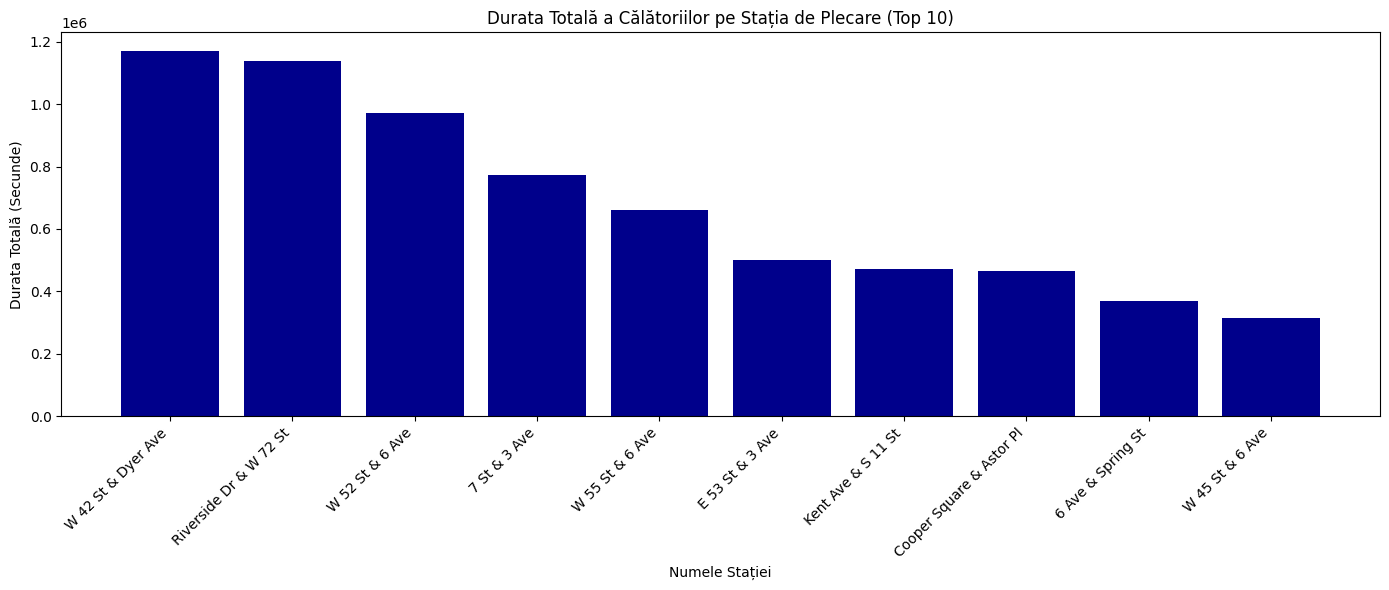

In [5]:
# ID: bfa2c902
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Grafic pentru durata totală a călătoriilor pe stație
stationwise_duration_pandas = stationwise_duration_df.orderBy(col("total_trip_duration_seconds").desc()).limit(10).toPandas()

plt.figure(figsize=(14, 6))
plt.bar(stationwise_duration_pandas['station_name'], stationwise_duration_pandas['total_trip_duration_seconds'], color='darkblue')
plt.title("Durata Totală a Călătoriilor pe Stația de Plecare (Top 10)")
plt.xlabel("Numele Stației")
plt.ylabel("Durata Totală (Secunde)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

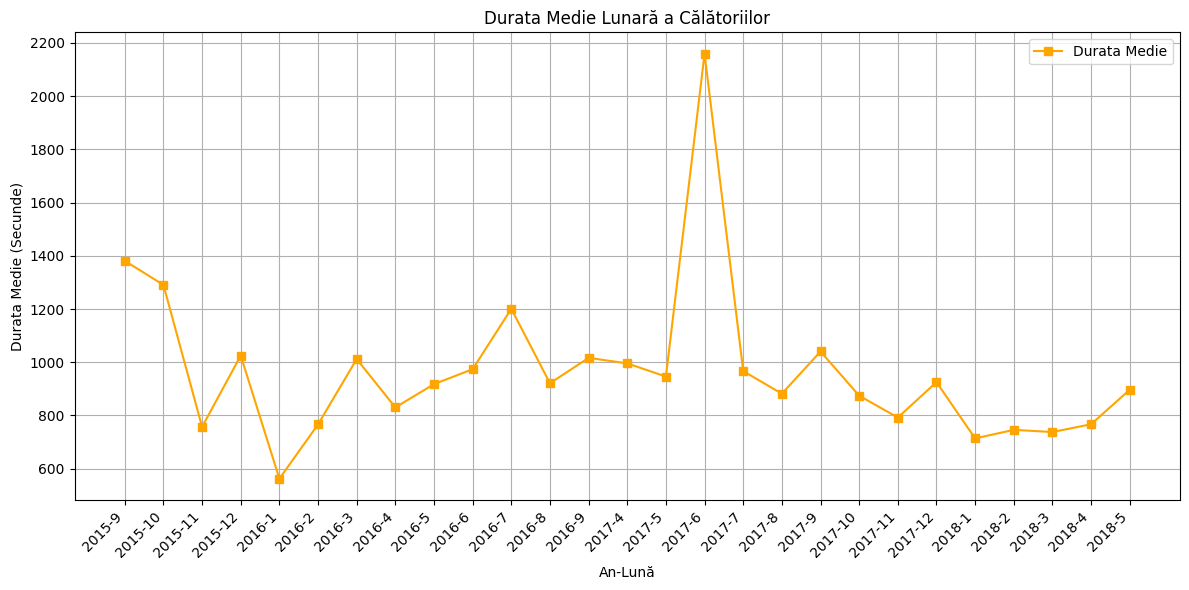

In [6]:
# ID: 59fe5288

# Grafic pentru durata medie a călătoriilor pe lună
monthly_avg_duration_pandas = monthly_avg_duration_df.orderBy("year", "month").toPandas()

# Creăm o etichetă combinată An-Lună
monthly_avg_duration_pandas['year_month'] = monthly_avg_duration_pandas['year'].astype(str) + '-' + monthly_avg_duration_pandas['month'].astype(str)

plt.figure(figsize=(12, 6))
plt.plot(monthly_avg_duration_pandas['year_month'], monthly_avg_duration_pandas['average_duration_seconds'], marker='s', color='orange', label="Durata Medie")
plt.title("Durata Medie Lunară a Călătoriilor")
plt.xlabel("An-Lună")
plt.ylabel("Durata Medie (Secunde)")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [7]:
# ID: abc9a209

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Variabila Țintă (Label): trip_duration_seconds
# Variabile Predictore (Features): station_id și calculated_distance_km
feature_cols = ["station_id", "calculated_distance_km"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Selectăm variabila țintă și caracteristicile, ignorând rândurile nule
data = assembler.transform(spark_df.select("trip_duration_seconds", *feature_cols).na.drop())

# Împărțim datele
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

print("Pregătirea datelor pentru modelare finalizată.")

Pregătirea datelor pentru modelare finalizată.


In [8]:
# ID: 4ee8770b

# Antrenare model (Labelul este trip_duration_seconds)
lr = LinearRegression(featuresCol="features", labelCol="trip_duration_seconds")
lr_model = lr.fit(train_data)

# Evaluare
predictions = lr_model.transform(test_data)

print("Comparație între durata călătoriei prezisă și cea reală:")
predictions.select("prediction", "trip_duration_seconds").show(5)

Comparație între durata călătoriei prezisă și cea reală:
+-----------------+---------------------+
|       prediction|trip_duration_seconds|
+-----------------+---------------------+
|66.99999999999973|                   67|
|73.00000000000037|                   73|
|73.00000000000051|                   73|
| 76.9999999999993|                   77|
|83.00000000000038|                   83|
+-----------------+---------------------+
only showing top 5 rows


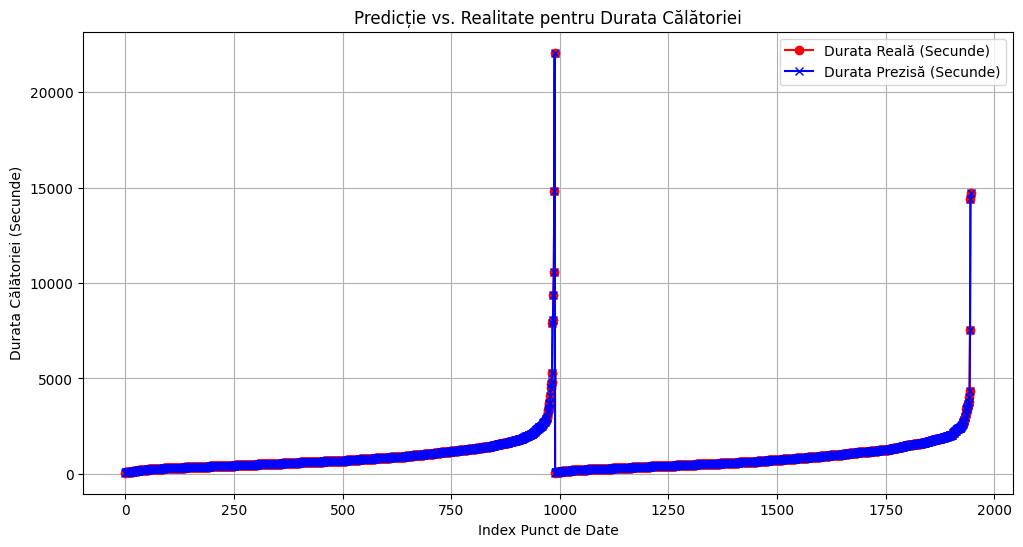

In [9]:
# ID: 55247bc4
import matplotlib.pyplot as plt

# Grafic pentru compararea duratei reale și prezise
predictions_pandas = predictions.select("prediction", "trip_duration_seconds").toPandas()

plt.figure(figsize=(12, 6))
# Etichete modificate pentru claritate
plt.plot(predictions_pandas.index, predictions_pandas['trip_duration_seconds'], label="Durata Reală (Secunde)", marker='o', color='red')
plt.plot(predictions_pandas.index, predictions_pandas['prediction'], label="Durata Prezisă (Secunde)", marker='x', color='blue')
plt.title("Predicție vs. Realitate pentru Durata Călătoriei")
plt.xlabel("Index Punct de Date")
plt.ylabel("Durata Călătoriei (Secunde)")
plt.legend()
plt.grid()
plt.show()